In [115]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

import numpy as np
import matplotlib.pyplot as plt
import SolveLinSys
from utilities import compute_derivatives_2d, find_nearest_value
from numba import njit

Equation:

$$
0 = \max_{e} \min_{h_2} -\delta \phi(y, z_2) + \delta \eta \log e - \delta(1-\eta) \left(\gamma_1 y z_2 + \frac{\gamma_2}{2}y^2z_2^2 \right) + \xi_m\frac{(h_2)^2}{2} + \frac{\partial \phi}{\partial y}(y, z_2) e  + \left[\frac{\partial \phi}{\partial z_2}(y, z_2)\right]\left[-\rho (z_2 -\mu_2) + \sqrt{z_2} \sigma_2 h_2\right] + \left[\frac{\partial^2 \phi}{\partial(z_2)^2}(y, z_2)\right]\left(\frac{z_2|\sigma_2|^2}{2}\right)
$$

FOC of $h_2$ gives : 

$$
h_2^* = -\frac{\left[\frac{\partial \phi}{\partial z_2}(y, z_2)\right]\sqrt{z_2}\sigma_2}{\xi_m}
$$

FOC of $e$ gives :

$$
e^* = -\frac{\delta \eta}{\frac{\partial \phi}{\partial y}(y, z_2)}
$$

In [116]:
def false_transient_one_iteration(stateSpace, A, B_z, B_y, C_zz, C_yy, D, v0, ε=.3, tol=-10):
    A = A.reshape(-1, 1, order='F')
    B = np.hstack([B_z.reshape(-1, 1, order='F'), B_y.reshape(-1, 1, order='F')])
    C = np.hstack([C_zz.reshape(-1, 1, order='F'), C_yy.reshape(-1, 1, order='F')])
    D = D.reshape(-1, 1, order='F')
    v0 = v0.reshape(-1, 1, order='F')
    out = SolveLinSys.solveFT(stateSpace, A, B, C, D, v0, ε, tol)
    return out


def false_transient(z_grid, y_grid, model_paras=(), v0=None, ϵ=.5, tol=1e-8, max_iter=10_000):
    η, ξ_m, δ, η, μ_2, ρ, σ_2, γ_1, γ_2 = model_paras

    Δ_z = z_grid[1] - z_grid[0]
    Δ_y = y_grid[1] - y_grid[0]
    (z_mat, y_mat) = np.meshgrid(z_grid, y_grid, indexing = 'ij')
    stateSpace = np.hstack([z_mat.reshape(-1, 1, order='F'), y_mat.reshape(-1, 1, order='F')])

    if v0 is None:
        v0 = np.zeros_like(z_mat)

    count = 1
    error = 1.

    while error > tol and count < max_iter:
        v_old = v0.copy()
        v0_dz = compute_derivatives_2d(v0, 0, 1, Δ_z)
        v0_dzz = compute_derivatives_2d(v0, 0, 2, Δ_z)
        v0_dy = compute_derivatives_2d(v0, 1, 1, Δ_y)

        e = -δ*η / v0_dy
        e[e<=0] = 1e-10
        h = -v0_dz*np.sqrt(z_mat)*σ_2 / ξ_m

        A = np.ones_like(z_mat)*(-δ)
        B_z = -ρ*(z_mat - μ_2) + np.sqrt(z_mat)*σ_2*h
        B_y = e
        C_zz = z_mat*σ_2**2/2
        C_yy = np.zeros_like(z_mat)
        D = δ*η*np.log(e) - δ*(1-η)*(γ_1*y_mat*z_mat+γ_2/2.*y_mat**2*z_mat**2) + ξ_m*h**2/2

        res = false_transient_one_iteration(stateSpace, A, B_z, B_y, C_zz, C_yy, D, v0, ϵ) # CG tol = 1e-10
        v0 = res[2].reshape(v0.shape, order = "F")

        rhs_error = A*v0 + B_z*v0_dz + B_y*v0_dy + C_zz*v0_dzz + D
        rhs_error = np.max(abs(rhs_error))
        lhs_error = np.max(abs((v0 - v_old)/ϵ))
        error = lhs_error

        print("Iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))
        count += 1
    print("Iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))
    return v0, e

In [117]:
# Model parameters
η = .032
ξ_m = .00256
δ = .01
# Z process
μ_2 = 1.86/1000.
ρ = 0.9
σ_2 = np.sqrt(2*ρ/10416.29)/2
# Damage setting
γ_1 = 1.7675/10000
γ_2 = 0.0022*2

pde_paras = (η, ξ_m, δ, η, μ_2, ρ, σ_2, γ_1, γ_2)

# Capital and z parameters
α_k = -0.0429
β_k = 0.04
σ_k = np.array([0.477*2, 0])/100.
β_z = 0.014*4
σ_z = np.array([0.011*2, 0.025*2])
α = 0.115
ioverk = 0.09
κ = 6.667

# Grid setting
n_z = 50
z_min = np.max([μ_2 - 6*np.sqrt(σ_2**2*μ_2/(2*ρ)), 1e-9])
z_max = μ_2 + 6*np.sqrt(σ_2**2*μ_2/(2*ρ))
z_grid = np.linspace(z_min, z_max, n_z)

n_y = 100
y_min = 1e-2
y_max = 4000.
y_grid = np.linspace(y_min, y_max, n_y)

In [ ]:
ϕ_grid, e_grid = false_transient(z_grid, y_grid, model_paras=pde_paras, v0=None, ϵ=.5, tol=1e-8, max_iter=10_000)

<ipython-input-116-f657132e25db>:31: RuntimeWarning: divide by zero encountered in true_divide
  e = -δ*η / v0_dy


Iteration 1: LHS Error: 0.009929180367537937; RHS Error 0.010673313396206382
Iteration 2: LHS Error: 0.0019230981693125898; RHS Error 0.003680179710417819
Iteration 3: LHS Error: 0.001989128652323368; RHS Error 0.0030769523684326255
Iteration 4: LHS Error: 0.0019395611570148194; RHS Error 0.002588043320736042
Iteration 5: LHS Error: 0.0018574084945424672; RHS Error 0.0022120475536835317
Iteration 6: LHS Error: 0.0017720319995438501; RHS Error 0.001957872484738079
Iteration 7: LHS Error: 0.0016958982363502765; RHS Error 0.0018004105609581724
Iteration 8: LHS Error: 0.0016410552186975455; RHS Error 0.0017005418849471636
Iteration 9: LHS Error: 0.0015927269073745679; RHS Error 0.0016367187642189634
Iteration 10: LHS Error: 0.0015492606860937038; RHS Error 0.0015873737618120076
Iteration 11: LHS Error: 0.0015096025206930083; RHS Error 0.0015434629602807276
Iteration 12: LHS Error: 0.0014730683440247073; RHS Error 0.0015036007032721782
Iteration 13: LHS Error: 0.0014391775314166917; RHS Err

Iteration 105: LHS Error: 0.0005167491957274659; RHS Error 0.000514407514246346
Iteration 106: LHS Error: 0.0005164708514009131; RHS Error 0.0005141577256109846
Iteration 107: LHS Error: 0.0005161662495763095; RHS Error 0.0005138811293550502
Iteration 108: LHS Error: 0.0005158360457049593; RHS Error 0.0005135783963722678
Iteration 109: LHS Error: 0.0005154808774928549; RHS Error 0.0005132501792383837
Iteration 110: LHS Error: 0.0005151013653858158; RHS Error 0.0005128971128745293
Iteration 111: LHS Error: 0.0005146981137514606; RHS Error 0.0005125198146338648
Iteration 112: LHS Error: 0.0005142717112878517; RHS Error 0.000512118888879056
Iteration 113: LHS Error: 0.0005138227293233211; RHS Error 0.0005116949175032394
Iteration 114: LHS Error: 0.0005133517270023077; RHS Error 0.0005112484723276687
Iteration 115: LHS Error: 0.0005128592468388177; RHS Error 0.0005107801048441963
Iteration 116: LHS Error: 0.0005123458183030338; RHS Error 0.0005102903615571824
Iteration 117: LHS Error: 0.00

Iteration 213: LHS Error: 0.00041317444963026584; RHS Error 0.00041232690651164913
Iteration 214: LHS Error: 0.00041195461158391455; RHS Error 0.00041111350886632923
Iteration 215: LHS Error: 0.00041073450884841767; RHS Error 0.0004098997866954976
Iteration 216: LHS Error: 0.00040951421084949036; RHS Error 0.000408685802988161
Iteration 217: LHS Error: 0.0004082937828416705; RHS Error 0.00040747162435334264
Iteration 218: LHS Error: 0.0004070732877784755; RHS Error 0.0004062573157394701
Iteration 219: LHS Error: 0.0004058527873343626; RHS Error 0.000405042939796928
Iteration 220: LHS Error: 0.00040463234212426147; RHS Error 0.0004038285579030838
Iteration 221: LHS Error: 0.00040341201688776085; RHS Error 0.00040261423035504497
Iteration 222: LHS Error: 0.0004021918594627888; RHS Error 0.0004014000194394955
Iteration 223: LHS Error: 0.00040097193185111013; RHS Error 0.0004001859771186961
Iteration 224: LHS Error: 0.0003997522917175145; RHS Error 0.00039897216290546596
Iteration 225: LHS

Iteration 325: LHS Error: 0.0002844597031516627; RHS Error 0.00028406488183894583
Iteration 326: LHS Error: 0.00028343465257985034; RHS Error 0.0002830422795996571
Iteration 327: LHS Error: 0.00028241228577144395; RHS Error 0.0002820223439643804
Iteration 328: LHS Error: 0.0002813926071707773; RHS Error 0.0002810050785993585
Iteration 329: LHS Error: 0.0002803756214533326; RHS Error 0.0002799904879385942
Iteration 330: LHS Error: 0.0002793613330821787; RHS Error 0.00027897857663305954
Iteration 331: LHS Error: 0.00027834974618426434; RHS Error 0.00027796934909673306
Iteration 332: LHS Error: 0.0002773408646155606; RHS Error 0.0002769628095305676
Iteration 333: LHS Error: 0.0002763346923856935; RHS Error 0.00027595896151972607
Iteration 334: LHS Error: 0.0002753312323238999; RHS Error 0.00027495780901468553
Iteration 335: LHS Error: 0.0002743304878499164; RHS Error 0.00027395935511429127
Iteration 336: LHS Error: 0.00027333246167873804; RHS Error 0.00027296360349093977
Iteration 337: LH

Iteration 434: LHS Error: 0.00018869170458918338; RHS Error 0.0001884840667245967
Iteration 435: LHS Error: 0.00018795831259810214; RHS Error 0.00018775184144921716
Iteration 436: LHS Error: 0.00018722741624349615; RHS Error 0.00018702210464551335
Iteration 437: LHS Error: 0.0001864990101898556; RHS Error 0.0001862948510069086
Iteration 438: LHS Error: 0.00018577308917711033; RHS Error 0.0001855700752336234
Iteration 439: LHS Error: 0.00018504964816742908; RHS Error 0.0001848477719699886
Iteration 440: LHS Error: 0.00018432868128992475; RHS Error 0.00018412793725722525
Iteration 441: LHS Error: 0.00018361018315488087; RHS Error 0.00018341056290540177
Iteration 442: LHS Error: 0.00018289414907543544; RHS Error 0.00018269564801113875
Iteration 443: LHS Error: 0.00018218057386809594; RHS Error 0.00018198318511279064
Iteration 444: LHS Error: 0.0001814694497759839; RHS Error 0.00018127316253394564
Iteration 445: LHS Error: 0.00018076077341011576; RHS Error 0.00018056558271568136
Iteration 

Iteration 534: LHS Error: 0.00012679403648790943; RHS Error 0.00012667408627038712
Iteration 535: LHS Error: 0.000126281904865716; RHS Error 0.00012616259619857047
Iteration 536: LHS Error: 0.0001257716867074099; RHS Error 0.00012565301591373098
Iteration 537: LHS Error: 0.00012526337612070448; RHS Error 0.0001251453395608661
Iteration 538: LHS Error: 0.00012475696721575558; RHS Error 0.00012463956125771013
Iteration 539: LHS Error: 0.00012425245411112895; RHS Error 0.00012413567515749593
Iteration 540: LHS Error: 0.00012374983093130232; RHS Error 0.00012363367540765634
Iteration 541: LHS Error: 0.00012324909180672083; RHS Error 0.00012313355615905115
Iteration 542: LHS Error: 0.00012275023087360282; RHS Error 0.0001226353115728358
Iteration 543: LHS Error: 0.00012225324227724266; RHS Error 0.00012213893581504637
Iteration 544: LHS Error: 0.00012175812016970711; RHS Error 0.00012164442306137317
Iteration 545: LHS Error: 0.0001212648587056997; RHS Error 0.00012115176748554653
Iteration 

Iteration 637: LHS Error: 8.309033055969861e-05; RHS Error 8.302068551269435e-05
Iteration 638: LHS Error: 8.274587576451164e-05; RHS Error 8.267659235767995e-05
Iteration 639: LHS Error: 8.240277687879272e-05; RHS Error 8.23338531512425e-05
Iteration 640: LHS Error: 8.206102909144586e-05; RHS Error 8.199246310123674e-05
Iteration 641: LHS Error: 8.172062760408716e-05; RHS Error 8.165241742259734e-05
Iteration 642: LHS Error: 8.13815676280194e-05; RHS Error 8.131371132653322e-05
Iteration 643: LHS Error: 8.104384439047707e-05; RHS Error 8.097634005883566e-05
Iteration 644: LHS Error: 8.070745450791672e-05; RHS Error 8.064029886292539e-05
Iteration 645: LHS Error: 8.037238861460794e-05; RHS Error 8.03055821252643e-05
Iteration 646: LHS Error: 8.003864602637578e-05; RHS Error 7.997218503341246e-05
Iteration 647: LHS Error: 7.970622175909603e-05; RHS Error 7.964010465554325e-05
Iteration 648: LHS Error: 7.937511082756199e-05; RHS Error 7.9309336028588e-05
Iteration 649: LHS Error: 7.90453

Iteration 741: LHS Error: 5.37115183388559e-05; RHS Error 5.367078716602059e-05
Iteration 742: LHS Error: 5.348461852242026e-05; RHS Error 5.344409517949719e-05
Iteration 743: LHS Error: 5.3258641859593725e-05; RHS Error 5.321832525638699e-05
Iteration 744: LHS Error: 5.303358483263465e-05; RHS Error 5.299347389269428e-05
Iteration 745: LHS Error: 5.280944393570852e-05; RHS Error 5.276953758371716e-05
Iteration 746: LHS Error: 5.258621567427735e-05; RHS Error 5.25465128395267e-05
Iteration 747: LHS Error: 5.236389656548823e-05; RHS Error 5.2324396186370083e-05
Iteration 748: LHS Error: 5.214248313759051e-05; RHS Error 5.210318415654674e-05
Iteration 749: LHS Error: 5.192197193146231e-05; RHS Error 5.188287329402439e-05
Iteration 750: LHS Error: 5.170235949888968e-05; RHS Error 5.166346016466437e-05
Iteration 751: LHS Error: 5.1483642402178065e-05; RHS Error 5.144494132731524e-05
Iteration 752: LHS Error: 5.126581721656698e-05; RHS Error 5.122731336782923e-05
Iteration 753: LHS Error: 5

Iteration 845: LHS Error: 3.4468881253052475e-05; RHS Error 3.444488442497424e-05
Iteration 846: LHS Error: 3.4321150676391854e-05; RHS Error 3.429727506312069e-05
Iteration 847: LHS Error: 3.417403509525796e-05; RHS Error 3.415028006308144e-05
Iteration 848: LHS Error: 3.4027532070685096e-05; RHS Error 3.4003897003516935e-05
Iteration 849: LHS Error: 3.3881616259945346e-05; RHS Error 3.3858123562161533e-05
Iteration 850: LHS Error: 3.373632249384362e-05; RHS Error 3.371293028124633e-05
Iteration 851: LHS Error: 3.3591637654095674e-05; RHS Error 3.3568359959400545e-05
Iteration 852: LHS Error: 3.3447557323901256e-05; RHS Error 3.342439553963506e-05
Iteration 853: LHS Error: 3.330407917087608e-05; RHS Error 3.328103261876638e-05
Iteration 854: LHS Error: 3.316120024468572e-05; RHS Error 3.313826888442606e-05
Iteration 855: LHS Error: 3.3018917455357455e-05; RHS Error 3.299610138384482e-05
Iteration 856: LHS Error: 3.2877227967881284e-05; RHS Error 3.285452706216997e-05
Iteration 857: LH

Iteration 954: LHS Error: 2.151937524150216e-05; RHS Error 2.150553865524227e-05
Iteration 955: LHS Error: 2.142601904192576e-05; RHS Error 2.1412251898132782e-05
Iteration 956: LHS Error: 2.1333058536437965e-05; RHS Error 2.1319360486744625e-05
Iteration 957: LHS Error: 2.1240492100893515e-05; RHS Error 2.1226862791020977e-05
Iteration 958: LHS Error: 2.1148318123692667e-05; RHS Error 2.1134757206043165e-05
Iteration 959: LHS Error: 2.1056534995456122e-05; RHS Error 2.10430421260238e-05
Iteration 960: LHS Error: 2.096514111538106e-05; RHS Error 2.095171595125863e-05
Iteration 961: LHS Error: 2.08741348883823e-05; RHS Error 2.086077708389998e-05
Iteration 962: LHS Error: 2.0783514722372276e-05; RHS Error 2.077022393362439e-05
Iteration 963: LHS Error: 2.0693279038058732e-05; RHS Error 2.068005493481757e-05
Iteration 964: LHS Error: 2.0603426254761636e-05; RHS Error 2.0590268490781492e-05
Iteration 965: LHS Error: 2.0513954802681145e-05; RHS Error 2.0500863044838622e-05
Iteration 966: L

Iteration 1067: LHS Error: 1.3132058181819506e-05; RHS Error 1.3124202558538022e-05
Iteration 1068: LHS Error: 1.3074496310078176e-05; RHS Error 1.3066680033655743e-05
Iteration 1069: LHS Error: 1.3017181772101427e-05; RHS Error 1.3009404755600696e-05
Iteration 1070: LHS Error: 1.2960113575821719e-05; RHS Error 1.2952375575586142e-05
Iteration 1071: LHS Error: 1.2903290760396535e-05; RHS Error 1.2895591517398774e-05
Iteration 1072: LHS Error: 1.2846712348330014e-05; RHS Error 1.2839051615918357e-05
Iteration 1073: LHS Error: 1.2790377344779058e-05; RHS Error 1.2782754899795426e-05
Iteration 1074: LHS Error: 1.2734284743881608e-05; RHS Error 1.2726700383900141e-05
Iteration 1075: LHS Error: 1.2678433533697131e-05; RHS Error 1.2670887059053869e-05
Iteration 1076: LHS Error: 1.2622822702673675e-05; RHS Error 1.2615313923496627e-05
Iteration 1077: LHS Error: 1.2567451242673222e-05; RHS Error 1.25599799724041e-05
Iteration 1078: LHS Error: 1.2512318146723489e-05; RHS Error 1.250488419487886

Iteration 1169: LHS Error: 8.37417826335396e-06; RHS Error 8.369474317256357e-06
Iteration 1170: LHS Error: 8.337178207112883e-06; RHS Error 8.332497725704782e-06
Iteration 1171: LHS Error: 8.3003389809988e-06; RHS Error 8.295681841512519e-06
Iteration 1172: LHS Error: 8.26365990286293e-06; RHS Error 8.259025992368404e-06
Iteration 1173: LHS Error: 8.2271402898626e-06; RHS Error 8.222529485268026e-06
Iteration 1174: LHS Error: 8.1907794654279e-06; RHS Error 8.1861916592793e-06
Iteration 1175: LHS Error: 8.154576752739118e-06; RHS Error 8.150011825659709e-06
Iteration 1176: LHS Error: 8.118531479917035e-06; RHS Error 8.113989319017247e-06
Iteration 1177: LHS Error: 8.082642976969812e-06; RHS Error 8.078123467079726e-06
Iteration 1178: LHS Error: 8.046910576792188e-06; RHS Error 8.042413607448247e-06
Iteration 1179: LHS Error: 8.011333614110772e-06; RHS Error 8.006859068367188e-06
Iteration 1180: LHS Error: 7.975911428786953e-06; RHS Error 7.971459197596785e-06
Iteration 1181: LHS Error:

Iteration 1276: LHS Error: 5.2048705896645675e-06; RHS Error 5.885653505317151e-06
Iteration 1277: LHS Error: 5.1817160191258704e-06; RHS Error 5.908786648902917e-06
Iteration 1278: LHS Error: 5.158652504944072e-06; RHS Error 5.931826041872851e-06
Iteration 1279: LHS Error: 5.135687278806644e-06; RHS Error 5.9547750723767945e-06
Iteration 1280: LHS Error: 5.112823279640466e-06; RHS Error 5.977625929586374e-06
Iteration 1281: LHS Error: 5.0900607620474325e-06; RHS Error 6.000375927195823e-06
Iteration 1282: LHS Error: 5.067399141661655e-06; RHS Error 6.0230249381183765e-06
Iteration 1283: LHS Error: 5.0448376849032694e-06; RHS Error 6.045573579804462e-06
Iteration 1284: LHS Error: 5.022375709429205e-06; RHS Error 6.068022582130851e-06
Iteration 1285: LHS Error: 5.000012612110805e-06; RHS Error 6.090372620385493e-06
Iteration 1286: LHS Error: 4.977747856960146e-06; RHS Error 6.112624287476435e-06
Iteration 1287: LHS Error: 4.9555809579771015e-06; RHS Error 6.1347781062273785e-06
Iteratio

Iteration 1389: LHS Error: 3.1389150974003854e-06; RHS Error 7.950396557110286e-06
Iteration 1390: LHS Error: 3.124852841679404e-06; RHS Error 7.964450960260515e-06
Iteration 1391: LHS Error: 3.1108528215084696e-06; RHS Error 7.978443162953556e-06
Iteration 1392: LHS Error: 3.096944941161084e-06; RHS Error 7.992373601382104e-06
Iteration 1393: LHS Error: 3.083066893533326e-06; RHS Error 8.006221704776463e-06
Iteration 1394: LHS Error: 3.0692448283464735e-06; RHS Error 8.020031378615656e-06
Iteration 1395: LHS Error: 3.05548328752292e-06; RHS Error 8.033784665506137e-06
Iteration 1396: LHS Error: 3.0417840641561167e-06; RHS Error 8.047477488086301e-06
Iteration 1397: LHS Error: 3.028147262745806e-06; RHS Error 8.061108244051488e-06
Iteration 1398: LHS Error: 3.014572272058702e-06; RHS Error 8.07467691253742e-06
Iteration 1399: LHS Error: 3.0010583809136904e-06; RHS Error 8.088184114321887e-06
Iteration 1400: LHS Error: 2.9876049771060398e-06; RHS Error 8.101630564196177e-06
Iteration 14

Iteration 1501: LHS Error: 1.8955787025043414e-06; RHS Error 9.193060061350755e-06
Iteration 1502: LHS Error: 1.8870356711664371e-06; RHS Error 9.201597851247263e-06
Iteration 1503: LHS Error: 1.8785305010982078e-06; RHS Error 9.210098296930547e-06
Iteration 1504: LHS Error: 1.8700633687696033e-06; RHS Error 9.218561045856656e-06
Iteration 1505: LHS Error: 1.861634300243109e-06; RHS Error 9.226985933336908e-06
Iteration 1506: LHS Error: 1.8532431912410274e-06; RHS Error 9.235372948390936e-06
Iteration 1507: LHS Error: 1.844889854024645e-06; RHS Error 9.243722199812573e-06
Iteration 1508: LHS Error: 1.8365740650783113e-06; RHS Error 9.252033876572566e-06
Iteration 1509: LHS Error: 1.828295594474838e-06; RHS Error 9.26030819941811e-06
Iteration 1510: LHS Error: 1.8200542199753311e-06; RHS Error 9.268545397031296e-06
Iteration 1511: LHS Error: 1.8118497294439262e-06; RHS Error 9.276745694290127e-06
Iteration 1512: LHS Error: 1.8036819247613245e-06; RHS Error 9.284909294262798e-06
Iteratio

Iteration 1604: LHS Error: 1.1892141949243484e-06; RHS Error 9.89906333724713e-06
Iteration 1605: LHS Error: 1.1838343400294438e-06; RHS Error 9.904438623928823e-06
Iteration 1606: LHS Error: 1.1784769348155422e-06; RHS Error 9.90979178192025e-06
Iteration 1607: LHS Error: 1.1731424031657944e-06; RHS Error 9.915122587652637e-06
Iteration 1608: LHS Error: 1.1678312721030704e-06; RHS Error 9.920430591380544e-06
Iteration 1609: LHS Error: 1.1625438732509874e-06; RHS Error 9.925715276061725e-06
Iteration 1610: LHS Error: 1.1572803091108863e-06; RHS Error 9.93097632663207e-06
Iteration 1611: LHS Error: 1.1520405362175357e-06; RHS Error 9.936213655251309e-06
Iteration 1612: LHS Error: 1.1468244385526294e-06; RHS Error 9.94142731418693e-06
Iteration 1613: LHS Error: 1.1416318781432011e-06; RHS Error 9.946617421405333e-06
Iteration 1614: LHS Error: 1.1364627147403272e-06; RHS Error 9.951784110925617e-06
Iteration 1615: LHS Error: 1.1313168131743545e-06; RHS Error 9.95692752509648e-06
Iteration

Iteration 1711: LHS Error: 7.31160893302496e-07; RHS Error 1.0356897964296826e-05
Iteration 1712: LHS Error: 7.278372487207196e-07; RHS Error 1.0360219984299767e-05
Iteration 1713: LHS Error: 7.245285683077363e-07; RHS Error 1.0363527047456021e-05
Iteration 1714: LHS Error: 7.212347860607871e-07; RHS Error 1.0366819219339814e-05
Iteration 1715: LHS Error: 7.179558353664905e-07; RHS Error 1.0370096568143832e-05
Iteration 1716: LHS Error: 7.14691649500443e-07; RHS Error 1.0373359163404466e-05
Iteration 1717: LHS Error: 7.114409218966777e-07; RHS Error 1.037660705794437e-05
Iteration 1718: LHS Error: 7.082065845986918e-07; RHS Error 1.03798393800953e-05
Iteration 1719: LHS Error: 7.04987634020382e-07; RHS Error 1.0383057486619345e-05
Iteration 1720: LHS Error: 7.01782823298025e-07; RHS Error 1.0386260401060339e-05
Iteration 1721: LHS Error: 6.985920338042906e-07; RHS Error 1.0389449262435764e-05
Iteration 1722: LHS Error: 6.954153705940325e-07; RHS Error 1.0392624168775982e-05
Iteration 1

Iteration 1822: LHS Error: 4.406213385821367e-07; RHS Error 1.0647293418987642e-05
Iteration 1823: LHS Error: 4.3861250093035764e-07; RHS Error 1.0649301316925945e-05
Iteration 1824: LHS Error: 4.366127153154764e-07; RHS Error 1.0651300171061323e-05
Iteration 1825: LHS Error: 4.3462194299070944e-07; RHS Error 1.0653290019870323e-05
Iteration 1826: LHS Error: 4.3264014490396185e-07; RHS Error 1.0655270899112752e-05
Iteration 1827: LHS Error: 4.306672816145607e-07; RHS Error 1.0657242850303848e-05
Iteration 1828: LHS Error: 4.2870331373734416e-07; RHS Error 1.0659205907416925e-05
Iteration 1829: LHS Error: 4.267482027198177e-07; RHS Error 1.066116011669765e-05
Iteration 1830: LHS Error: 4.248019079278187e-07; RHS Error 1.066310551009345e-05
Iteration 1831: LHS Error: 4.228643919468311e-07; RHS Error 1.0665042134146141e-05
Iteration 1832: LHS Error: 4.209356135875808e-07; RHS Error 1.0666970023697321e-05
Iteration 1833: LHS Error: 4.190155353522851e-07; RHS Error 1.0668889216434128e-05
It

Iteration 1938: LHS Error: 2.5894669397619197e-07; RHS Error 1.0828896359059404e-05
Iteration 1939: LHS Error: 2.5775949769046846e-07; RHS Error 1.0830082996962469e-05
Iteration 1940: LHS Error: 2.56577688234616e-07; RHS Error 1.083126424831582e-05
Iteration 1941: LHS Error: 2.554012423217067e-07; RHS Error 1.0832440144628054e-05
Iteration 1942: LHS Error: 2.542301354435672e-07; RHS Error 1.0833610701567735e-05
Iteration 1943: LHS Error: 2.5306434428551405e-07; RHS Error 1.083477594371107e-05
Iteration 1944: LHS Error: 2.5190384411732936e-07; RHS Error 1.0835935896769751e-05
Iteration 1945: LHS Error: 2.5074861281781935e-07; RHS Error 1.0837090590092805e-05
Iteration 1946: LHS Error: 2.495986242689874e-07; RHS Error 1.0838240037426181e-05
Iteration 1947: LHS Error: 2.4845385754312943e-07; RHS Error 1.0839384268740968e-05
Iteration 1948: LHS Error: 2.473142873549161e-07; RHS Error 1.0840523302673463e-05
Iteration 1949: LHS Error: 2.4617989116682004e-07; RHS Error 1.0841657172127141e-05


Iteration 2042: LHS Error: 1.60073402255545e-07; RHS Error 1.092770840535281e-05
Iteration 2043: LHS Error: 1.5933279626234587e-07; RHS Error 1.092844877852682e-05
Iteration 2044: LHS Error: 1.5859561020015178e-07; RHS Error 1.0929185736369444e-05
Iteration 2045: LHS Error: 1.5786182988586361e-07; RHS Error 1.0929919284117162e-05
Iteration 2046: LHS Error: 1.57131438666136e-07; RHS Error 1.0930649447558915e-05
Iteration 2047: LHS Error: 1.564051173574832e-07; RHS Error 1.0931376219301583e-05
Iteration 2048: LHS Error: 1.5567908798197472e-07; RHS Error 1.0932101506291988e-05
Iteration 2049: LHS Error: 1.5495792113351392e-07; RHS Error 1.0932819965403691e-05
Iteration 2050: LHS Error: 1.5424005792019635e-07; RHS Error 1.0933536693973089e-05
Iteration 2051: LHS Error: 1.535253066620168e-07; RHS Error 1.0934251061620807e-05
Iteration 2052: LHS Error: 1.5281399828870335e-07; RHS Error 1.0934962294838852e-05
Iteration 2053: LHS Error: 1.521061817055802e-07; RHS Error 1.0935670088368802e-05
I

Iteration 2150: LHS Error: 9.684387580755072e-08; RHS Error 1.0990909670861642e-05
Iteration 2151: LHS Error: 9.639084877499648e-08; RHS Error 1.0991362887278078e-05
Iteration 2152: LHS Error: 9.594037247984133e-08; RHS Error 1.0991813649287882e-05
Iteration 2153: LHS Error: 9.549240001516246e-08; RHS Error 1.099226187945484e-05
Iteration 2154: LHS Error: 9.504683723404739e-08; RHS Error 1.0992707625100422e-05
Iteration 2155: LHS Error: 9.460358868507157e-08; RHS Error 1.0993150982056225e-05
Iteration 2156: LHS Error: 9.416257357175439e-08; RHS Error 1.0993592047631672e-05
Iteration 2157: LHS Error: 9.372374712435239e-08; RHS Error 1.0994030894313973e-05
Iteration 2158: LHS Error: 9.32871659642398e-08; RHS Error 1.0994467583132e-05
Iteration 2159: LHS Error: 9.285263530278698e-08; RHS Error 1.099490215770131e-05
Iteration 2160: LHS Error: 9.24201444540973e-08; RHS Error 1.0995334648852167e-05
Iteration 2161: LHS Error: 9.19896852857871e-08; RHS Error 1.0995765082618216e-05
Iteration 21

Iteration 2263: LHS Error: 5.695015947715376e-08; RHS Error 1.1030801022880764e-05
Iteration 2264: LHS Error: 5.6683596177942164e-08; RHS Error 1.1031067533912432e-05
Iteration 2265: LHS Error: 5.641830910785295e-08; RHS Error 1.1031332768202205e-05
Iteration 2266: LHS Error: 5.615429160554797e-08; RHS Error 1.1031596733145587e-05
Iteration 2267: LHS Error: 5.5891538452979006e-08; RHS Error 1.1031859434368504e-05
Iteration 2268: LHS Error: 5.5630042239407373e-08; RHS Error 1.1032120875210786e-05
Iteration 2269: LHS Error: 5.536979788556273e-08; RHS Error 1.103238106509144e-05
Iteration 2270: LHS Error: 5.511079895215154e-08; RHS Error 1.1032640012500637e-05
Iteration 2271: LHS Error: 5.485303847252432e-08; RHS Error 1.1032897717106122e-05
Iteration 2272: LHS Error: 5.459651217232242e-08; RHS Error 1.103315419236832e-05
Iteration 2273: LHS Error: 5.4341212279984674e-08; RHS Error 1.103340943967154e-05
Iteration 2274: LHS Error: 5.408713335541826e-08; RHS Error 1.1033663462128526e-05
Ite

Iteration 2385: LHS Error: 3.1995895544145725e-08; RHS Error 1.1055746252029242e-05
Iteration 2386: LHS Error: 3.184623220686689e-08; RHS Error 1.1055895901008973e-05
Iteration 2387: LHS Error: 3.1697302282918116e-08; RHS Error 1.1056044822495119e-05
Iteration 2388: LHS Error: 3.154910022118429e-08; RHS Error 1.1056193014539909e-05
Iteration 2389: LHS Error: 3.140162435633087e-08; RHS Error 1.1056340477620826e-05
Iteration 2390: LHS Error: 3.125486949806522e-08; RHS Error 1.1056487226293338e-05
Iteration 2391: LHS Error: 3.110883226020711e-08; RHS Error 1.1056633254944153e-05
Iteration 2392: LHS Error: 3.0963509700665526e-08; RHS Error 1.10567785644602e-05
Iteration 2393: LHS Error: 3.0818896906703586e-08; RHS Error 1.105692316994794e-05
Iteration 2394: LHS Error: 3.067499160236409e-08; RHS Error 1.1057067065118784e-05
Iteration 2395: LHS Error: 3.0531789013688027e-08; RHS Error 1.1057210258370366e-05
Iteration 2396: LHS Error: 3.038928617082881e-08; RHS Error 1.1057352750184287e-05
It

Iteration 2485: LHS Error: 2.010823188514088e-08; RHS Error 1.1067621127877397e-05
Iteration 2486: LHS Error: 2.0015862606248547e-08; RHS Error 1.106771350051634e-05
Iteration 2487: LHS Error: 1.9923939359456355e-08; RHS Error 1.1067805434615346e-05
Iteration 2488: LHS Error: 1.983245920267329e-08; RHS Error 1.1067896936318153e-05
Iteration 2489: LHS Error: 1.974141988769773e-08; RHS Error 1.106798800164585e-05
Iteration 2490: LHS Error: 1.9650819305105927e-08; RHS Error 1.1068078631368923e-05
Iteration 2491: LHS Error: 1.956065484587377e-08; RHS Error 1.1068168828732065e-05
Iteration 2492: LHS Error: 1.947092456711097e-08; RHS Error 1.1068258592187089e-05
Iteration 2493: LHS Error: 1.9394001821160245e-08; RHS Error 1.106834793352903e-05
Iteration 2494: LHS Error: 1.9291555519718173e-08; RHS Error 1.1068441975126565e-05
Iteration 2495: LHS Error: 1.919832748331629e-08; RHS Error 1.106853260983778e-05
Iteration 2496: LHS Error: 1.9104739873432308e-08; RHS Error 1.1068625501681033e-05
It

In [ ]:
@njit(parallel=True)
def simulate_emission(e_grid, y_grid, y_start=290, z_loc=25, T=100):
    Et = np.zeros(T+1)
    for i in range(T+1):
        Et[i] = np.interp(y_start, y_grid, e_grid[z_loc])
        y_start = y_start + Et[i]
    return Et


@njit(parallel=True)
def simulate_capital(α_k, β_k, σ_k, β_z, σ_z, ioverk, κ, Ws, k_start, N=100_000, T=100, dt=1.):
    var_z = dt*σ_z@σ_z/(1-(1-β_z*dt)**2)
    std_z = np.sqrt(var_z)

    time_periods = int(T/dt)
    z_path = np.zeros((N, time_periods+1))
    k_path = np.zeros((N, time_periods+1))
    for i in range(N):
        z0 = np.random.normal(0.,std_z)
        k0 = k_start
        z_path[i, 0] = z0
        k_path[i, 0] = k0
        for j in range(1, time_periods+1):
            k1 = k0 + (α_k + β_k*z0 + ioverk - κ/2.*ioverk**2 - σ_k@σ_k/2.)*dt + σ_k@Ws[i, j]*np.sqrt(dt)
            z1 = (1.-β_z*dt)*z0 + σ_z@Ws[i, j]*np.sqrt(dt)
            k_path[i, j] = k1
            z_path[i, j] = z1
            k0 = k1
            z0 = z1
    return k_path

In [23]:
T = 100
Et = simulate_emission(e_grid, y_grid, y_start=290, z_loc=25, T=T)

In [89]:
T = 100
N = 1_000_000
dt = 1.
# k_start = np.log(80/α)
k_start = np.log(695)
Ws = np.random.multivariate_normal(np.zeros(2), np.eye(2), (N, int(T/dt)))
logk_path = simulate_capital(α_k, β_k, σ_k, β_z, σ_z, ioverk, κ, Ws, k_start, N=N, T=T, dt=dt)
Kt = np.percentile(np.exp(logk_path), 50, axis=0)

In [90]:
# SCCt = η*(α-ioverk)*Kt/((1.-η)*Et)
SCCt = η*(0.025)*Kt/((1.-η)*Et)

Text(0.5, 0, 'Year')

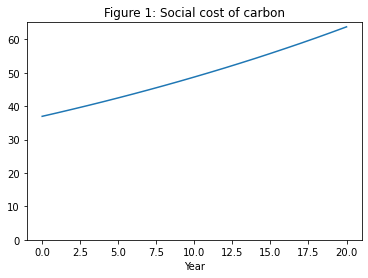

In [91]:
plt.plot(SCCt[:21]*1000)
plt.ylim(0, None)
plt.title('Figure 1: Social cost of carbon')
plt.xlabel('Year')
# plt.savefig('figure_1.pdf')

In [61]:
import pickle
with open('scc_bhh.pkl', 'rb') as f:
    scc_bhh = pickle.load(f)
with open('emission.pkl', 'rb') as f:
    emission_bbh = pickle.load(f)

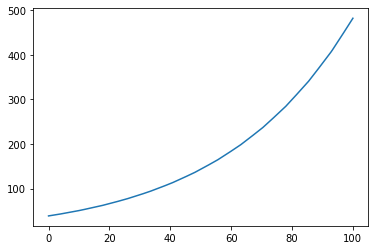

In [40]:
plt.plot(scc_bhh[0]['x'], scc_bhh[0]['y'])

In [45]:
scc_low = np.array([scc_bhh[0]['y'][4*i] for i in range(21)])

### SCC formula

$$
SCC = \frac{\eta\left[\color{red}{\alpha - \left(\frac{i}{k}\right)^*}\right]K_t^*}{(1-\eta)E_t^*}
$$

(1) in BBH, $\alpha=0.115, \left(\frac{i}{k}\right)^*=0.09$, so $\left[\alpha - \left(\frac{i}{k}\right)^*\right]=0.025$.

(2) in the new paper, $\alpha=0.2, \left(\frac{i}{k}\right)^*=0.125$, so $\left[\alpha - \left(\frac{i}{k}\right)^*\right]=0.075$.

### Adjustment cost parameters

$\alpha=0.115, \left(\frac{i}{k}\right)^*=0.09$

From FOC of $\frac{i}{k}$, we have:
$$
1-\kappa \left(\frac{i}{k}\right)^* - \frac{\delta}{\alpha-\left(\frac{i}{k}\right)^*} = 0 
$$

Therefore $\kappa=6.667$

In [102]:
(1-δ/(α-ioverk))/ioverk

6.666666666666668

In [114]:
-0.0429 + ioverk - κ/2.*ioverk**2

0.02009865

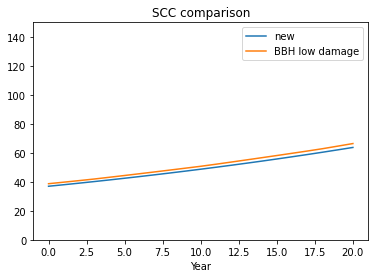

In [92]:
plt.plot(SCCt[:21]*1000, label='new')
plt.plot(scc_low, label='BBH low damage')
plt.ylim(0, 150)
plt.xlabel('Year')
plt.legend()
plt.title('SCC comparison')
plt.savefig('scc.pdf')

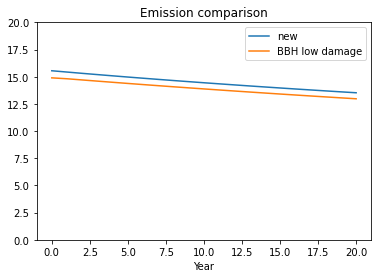

In [71]:
plt.plot(Et[:21], label='new')
plt.plot(emission_low, label='BBH low damage')
plt.ylim(0, 20)
plt.xlabel('Year')
plt.legend()
plt.title('Emission comparison')
plt.savefig('emission.pdf')

In [66]:
emission_low = np.array([emission_bbh[0]['y'][4*i] for i in range(21)])